In [1]:
# Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns
from explore import xgb_rank

# Feature Selection
from explore import get_scaled_df
import xgboost as xgb
from sklearn.decomposition import PCA

# Evaluate Algorithms

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data

import model
from model import polynomial_regression_model
from model import run_models

import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import sys 

**Let's bring in the DataFrame**

In [3]:
df = acquire_oil()
df = prep_data(df)

**(Rows, Columns)**

In [4]:
df.shape

(7808, 58)

In [5]:
df.columns

Index(['api14', 'lease_name', 'well_number', 'county', 'direction', 'status',
       'oper', 'multi_well_lease', 'major_phase', 'formation', 'proppant_ppf',
       'prod_method', 'frac_fluid_gpf', 'gross_perfs', 'frac_stages',
       'frac_fluid_type', 'first_prod', 'last_prod', 'peak_boepd', 'oil_hist',
       'gas_hist', 'gor_hist', 'ip90_boeqpd', 'tvd', 'sur_lat', 'sur_long',
       'well_id', 'mid_point_lat', 'mid_point_long', 'sub_basin', 'recovery',
       'recovery_per_foot', 'months_active', 'recovery_per_month',
       'lateral_class', 'vintage', 'vintage_bin', 'encoded_direction',
       'encoded_frac_fluid_type', 'encoded_county', 'encoded_oper',
       'encoded_formation', 'encoded_lateral_class', 'scaled_direction',
       'scaled_frac_fluid_type', 'scaled_county', 'scaled_oper',
       'scaled_formation', 'scaled_lateral_class', 'scaled_proppant_ppf',
       'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 'scaled_frac_stages',
       'scaled_gor_hist', 'scaled_tvd', 'scale

### XGBoost Feature Recommender

In [6]:
feature_list, scaled_features, importance_df = xgb_rank(df,df.recovery,feature_percent=80,mode='gain')
feature_list

['tvd',
 'vintage',
 'gross_perfs',
 'mid_point_long',
 'mid_point_lat',
 'formation',
 'direction']

In [7]:
scaled_features

['scaled_tvd',
 'scaled_vintage',
 'scaled_gross_perfs',
 'scaled_mid_point_long',
 'scaled_mid_point_lat',
 'scaled_formation',
 'scaled_direction']

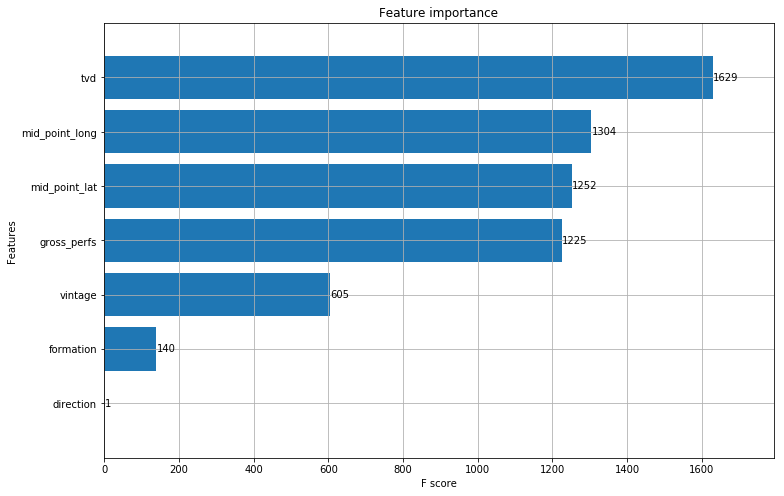

In [8]:
xgb_df = get_scaled_df(df).drop(columns=['recovery'])
xgb_df = xgb_df[feature_list]

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}

dtrain = xgb.DMatrix(xgb_df, df.oil_hist, feature_names=xgb_df.columns.values)
xgb_model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(xgb_model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [9]:
importance_df

,rank,feature,gain,cum_sum,cum_perc
0,1.0,tvd,87229.05,87229.05,19.48
1,2.0,vintage,71315.50,158544.55,35.40
2,3.0,gross_perfs,43329.88,201874.43,45.08
3,4.0,mid_point_long,40933.56,242807.99,54.22
4,5.0,mid_point_lat,38461.47,281269.46,62.81
5,6.0,formation,35619.71,316889.17,70.76
6,7.0,direction,24558.81,341447.98,76.25
7,8.0,frac_stages,19687.30,361135.28,80.64
8,9.0,frac_fluid_gpf,16347.17,377482.45,84.29
9,10.0,gor_hist,16263.12,393745.57,87.93


In [10]:
sorted_list = ['tvd', 'vintage', 'gross_perfs', 'mid_point_lat', 'mid_point_long', 'formation', 'direction']

<BarContainer object of 7 artists>

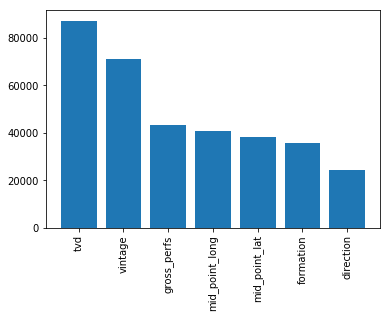

In [11]:
plt.xticks(rotation=90)
plt.bar(importance_df.feature[:7], importance_df.gain[:7])

# Test Harness and Options

### Results for the entire dataframe to use as a baseline before clustering

In [12]:
feature_list

['tvd',
 'vintage',
 'gross_perfs',
 'mid_point_long',
 'mid_point_lat',
 'formation',
 'direction']

In [13]:
xfeatures = ['tvd', 'vintage', 'gross_perfs', 'mid_point_lat', 'mid_point_long', 'encoded_formation', 'encoded_direction'] 
yfeature = ['recovery']

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 105.30489945968837
R2 score of training set is 0.27126339131095356


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.25030163 0.26702956 0.28939013]


The model performance for the test set
-------------------------------------------
RMSE of test set is 104.82496108827577
R2 score of test set is 0.24416125936614685




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 105.11359305847611
R2 score of training set is 0.27390876383497975


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.25297262 0.26988355 0.29139935]


The model performance for the test set
-------------------------------------------
RMSE of test set is 

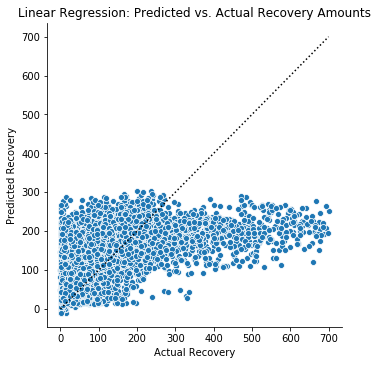

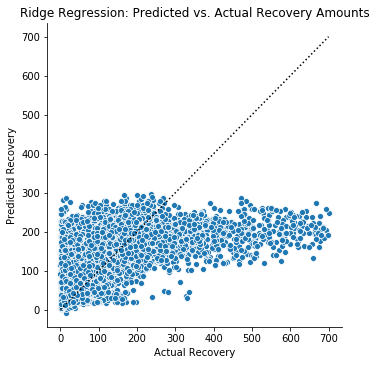

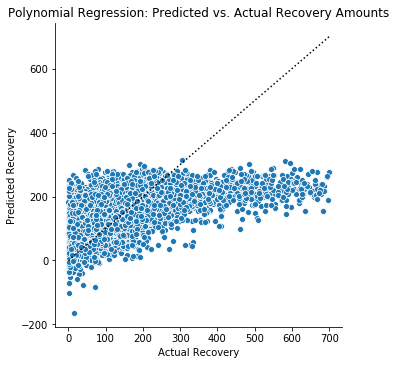

In [14]:
model.run_models(df, xfeatures, yfeature, 0.80, 'full')

**Let's Cluster by our Top Seven features per our XGBoost function**

In [15]:
feature_list

['tvd',
 'vintage',
 'gross_perfs',
 'mid_point_long',
 'mid_point_lat',
 'formation',
 'direction']

In [16]:
scaled_features

['scaled_tvd',
 'scaled_vintage',
 'scaled_gross_perfs',
 'scaled_mid_point_long',
 'scaled_mid_point_lat',
 'scaled_formation',
 'scaled_direction']

#### Check to see which fields need to be encoded.

In [17]:
col_list = scaled_features

**We now have a new dataframe with an added column "cluster_id"**

In [18]:
df = model.create_kclusters(df, col_list, 3, 'cluster_id')

**Let's see how many oberservations we have in each cluster**

In [19]:
df.cluster_id.value_counts()

2    4786
0    1809
1    1213
Name: cluster_id, dtype: int64

**Let's take a look at the differences between the clusters**

In [58]:
df.groupby('cluster_id')['tvd', 'vintage', 'gross_perfs', 'mid_point_long', 'mid_point_lat', 'encoded_formation', 'encoded_direction'].describe().T

cluster_id                          0             1             2
tvd               count   1809.000000   1213.000000   4786.000000
                  mean    8355.725263    126.003298   8182.381738
                  std     2888.764215   1074.825358   1290.159923
                  min        0.000000      0.000000      0.000000
                  25%     5563.000000      0.000000   7133.000000
                  50%     8762.000000      0.000000   8281.500000
                  75%    11045.000000      0.000000   9310.750000
                  max    13153.000000  12698.000000  13434.000000
vintage           count   1809.000000   1213.000000   4786.000000
                  mean    2013.414041   1997.562242   2014.636440
                  std        2.857888     13.166506      1.820320
                  min     1990.000000   1958.000000   1996.000000
                  25%     2012.000000   1997.000000   2014.000000
                  50%     2014.000000   2000.000000   2015.000000
                  75%     2015.000000   2008.000000   2016.000000
                  max     2018.000000   2016.000000   2018.000000
gross_perfs       count   1809.000000   1213.000000   4786.000000
                  mean    4380.948590    793.811212   7465.535729
                  std     1370.096549    578.570554   1867.043093
                  min      640.000000      4.000000    710.000000
                  25%     3865.000000    201.000000   6518.500000
                  50%     4325.000000    705.000000   7508.000000
                  75%     4761.000000   1492.000000   8702.750000
                  max    10754.000000   1600.000000  13581.000000
mid_point_long    count   1809.000000   1213.000000   4786.000000
                  mean    -103.080920   -101.637467   -101.641773
                  std        0.638394      0.329233      0.386325
                  min     -104.340768   -103.391103   -103.319402
                  25%     -103.616901   -101.809414   -101.970864
                  50%     -102.992239   -101.636034   -101.620734
                  75%     -102.644119   -101.331838   -101.339623
                  max     -100.836180   -101.130513   -100.691821
mid_point_lat     count   1809.000000   1213.000000   4786.000000
                  mean      32.010382     31.776501     31.583998
                  std        0.508618      0.323276      0.428321
                  min       30.661667     30.447167     30.591857
                  25%       31.713519     31.538340     31.239002
                  50%       31.920038     31.731739     31.550803
                  75%       32.182869     32.099922     31.879252
                  max       33.669249     32.604670     32.924760
encoded_formation count   1809.000000   1213.000000   4786.000000
                  mean      18.977888     19.276999     28.394693
                  std       10.738111      8.289070      2.752843
                  min        0.000000      0.000000      3.000000
                  25%        7.000000     10.000000     29.000000
                  50%       21.000000     24.000000     29.000000
                  75%       29.000000     24.000000     29.000000
                  max       34.000000     37.000000     37.000000
encoded_direction count   1809.000000   1213.000000   4786.000000
                  mean       0.000000      1.000000      0.000000
                  std        0.000000      0.000000      0.000000
                  min        0.000000      1.000000      0.000000
                  25%        0.000000      1.000000      0.000000
                  50%        0.000000      1.000000      0.000000
                  75%        0.000000      1.000000      0.000000
                  max        0.000000      1.000000      0.000000

In [21]:
df.groupby('cluster_id')['direction'].value_counts()

cluster_id  direction 
0           Horizontal    1809
1           Vertical      1213
2           Horizontal    4786
Name: direction, dtype: int64

**A few keep takeaways:**

**Cluster 0 (short_horizontals) contains horizontal wells that tend to be shorter in lateral length/gross perfs**

**Cluster 1 (verticals) contains all, and solely, vertical wells**

**Cluster 2 (long_horizontals) contains horizontal wells that tend to be longer in lateral length/gross perfs**

In [22]:
df.to_excel('CapstoneDataFinal.xlsx')

# ALL Regression Types on Each Cluster

### short_horizontals (cluster 0): 1,809 Oberservations

In [23]:
short_horizontals = df[df['cluster_id'] == 0]

In [24]:
short_horizontals.shape

(1809, 59)

In [25]:
feature_list, scaled_features, importance_df = xgb_rank(short_horizontals, short_horizontals.recovery, feature_percent=80, mode='gain')
feature_list

['mid_point_long',
 'vintage',
 'oper',
 'mid_point_lat',
 'tvd',
 'gor_hist',
 'gross_perfs']

#### Check to see which of those features need to be encoded.

In [26]:
xfeatures = ['mid_point_long', 'vintage', 'encoded_oper', 'mid_point_lat', 'tvd', 'gor_hist', 'gross_perfs']
yfeature = ['recovery']

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 114.3074146803639
R2 score of training set is 0.3000208892515066


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.29316606 0.23041919 0.28994169]


The model performance for the test set
-------------------------------------------
RMSE of test set is 111.54703465600726
R2 score of test set is 0.32780604483295717




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 111.58375681830039
R2 score of training set is 0.33298095616167744


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.30961815 0.27757973 0.31761515]


The model performance for the test set
-------------------------------------------
RMSE of test set is 11

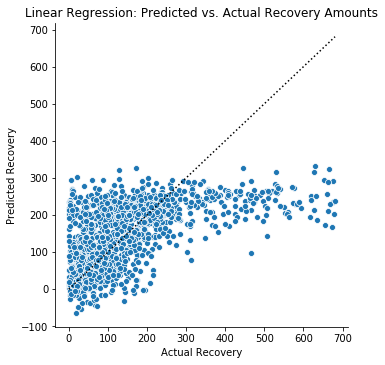

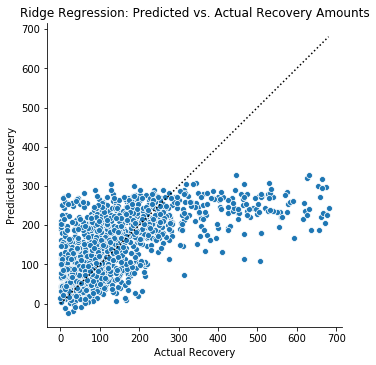

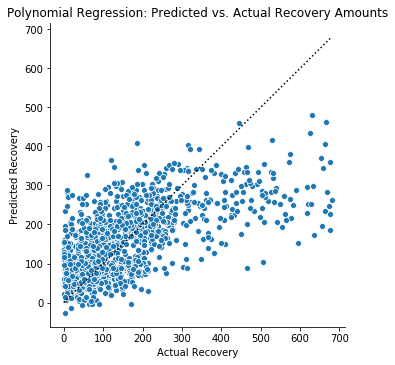

In [27]:
model.run_models(short_horizontals, xfeatures, yfeature, 0.70, 'horizontal_short')

### verticals (cluster 1):  1,213 Observations

In [28]:
verticals = df[df['cluster_id'] == 1]

In [29]:
verticals.shape

(1213, 59)

In [30]:
feature_list, scaled_features, importance_df = xgb_rank(verticals, verticals.recovery, feature_percent=80,mode='gain')
feature_list

['vintage', 'gor_hist', 'gross_perfs', 'tvd', 'formation']

#### Check to see which of those features need to be encoded.

In [31]:
xfeatures = ['vintage', 'gor_hist', 'gross_perfs', 'tvd', 'encoded_formation']
yfeature = ['recovery']

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 34.5279948737237
R2 score of training set is 0.25095339405963146


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.24923437 0.20526416 0.24118265]


The model performance for the test set
-------------------------------------------
RMSE of test set is 35.92264841027267
R2 score of test set is 0.16855577971374847




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 32.74776086685405
R2 score of training set is 0.3262025792046377


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.32911587 0.26351468 0.32925651]


The model performance for the test set
-------------------------------------------
RMSE of test set is 34.15

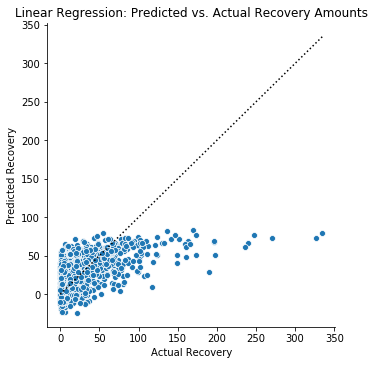

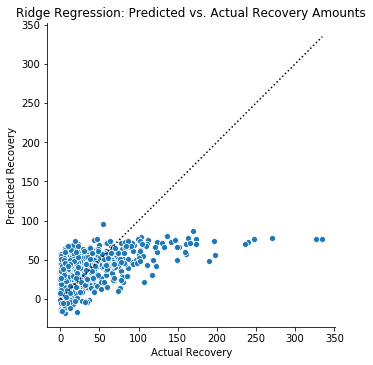

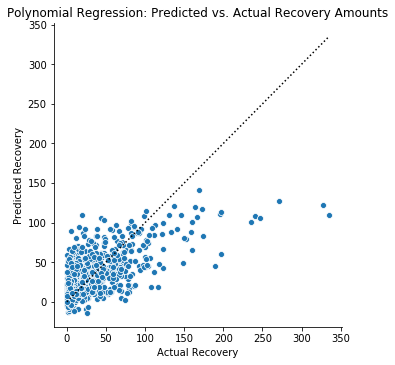

In [32]:
model.run_models(verticals, xfeatures, yfeature, 0.70, 'vertical')

### long_horizontals (cluster 2): 4,786 Observations

In [33]:
long_horizontals = df[df['cluster_id'] == 2]

In [34]:
long_horizontals.shape

(4786, 59)

In [35]:
feature_list, scaled_features, importance_df = xgb_rank(long_horizontals, long_horizontals.recovery, feature_percent=80, mode='gain')
feature_list

['vintage',
 'mid_point_lat',
 'formation',
 'gross_perfs',
 'mid_point_long',
 'tvd',
 'frac_fluid_gpf']

#### Check to see which of those features need to be encoded.

In [36]:
xfeatures = ['vintage', 'mid_point_lat', 'encoded_formation', 'gross_perfs', 'mid_point_long', 'tvd', 'frac_fluid_gpf']
yfeature = ['recovery']

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 104.71051072184355
R2 score of training set is 0.14923078476739093


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.11732898 0.17641534 0.1455413 ]


The model performance for the test set
-------------------------------------------
RMSE of test set is 110.87573374237672
R2 score of test set is 0.14508143191428902




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 104.68927381961402
R2 score of training set is 0.14957584793851375


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.11792167 0.17499804 0.14609692]


The model performance for the test set
-------------------------------------------
RMSE of test set is 

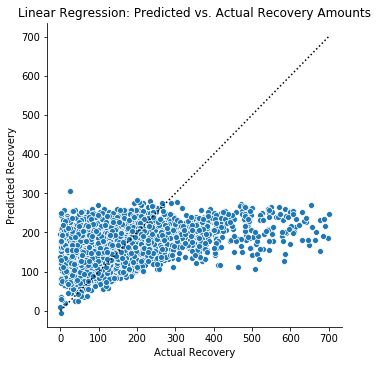

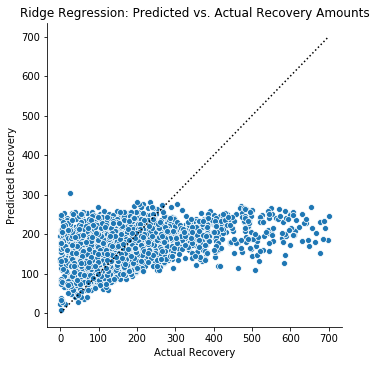

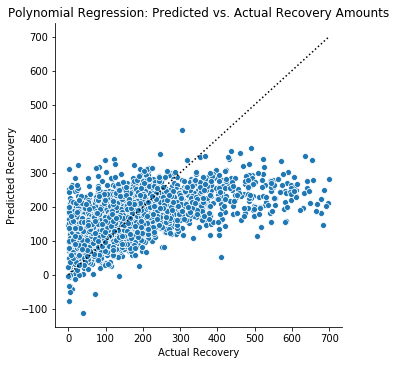

In [37]:
model.run_models(long_horizontals, xfeatures, yfeature, 0.70, 'horizontal_long')

In [39]:
df.columns

Index(['api14', 'lease_name', 'well_number', 'county', 'direction', 'status',
       'oper', 'multi_well_lease', 'major_phase', 'formation', 'proppant_ppf',
       'prod_method', 'frac_fluid_gpf', 'gross_perfs', 'frac_stages',
       'frac_fluid_type', 'first_prod', 'last_prod', 'peak_boepd', 'oil_hist',
       'gas_hist', 'gor_hist', 'ip90_boeqpd', 'tvd', 'sur_lat', 'sur_long',
       'well_id', 'mid_point_lat', 'mid_point_long', 'sub_basin', 'recovery',
       'recovery_per_foot', 'months_active', 'recovery_per_month',
       'lateral_class', 'vintage', 'vintage_bin', 'encoded_direction',
       'encoded_frac_fluid_type', 'encoded_county', 'encoded_oper',
       'encoded_formation', 'encoded_lateral_class', 'scaled_direction',
       'scaled_frac_fluid_type', 'scaled_county', 'scaled_oper',
       'scaled_formation', 'scaled_lateral_class', 'scaled_proppant_ppf',
       'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 'scaled_frac_stages',
       'scaled_gor_hist', 'scaled_tvd', 'scale

## Interpret and report results

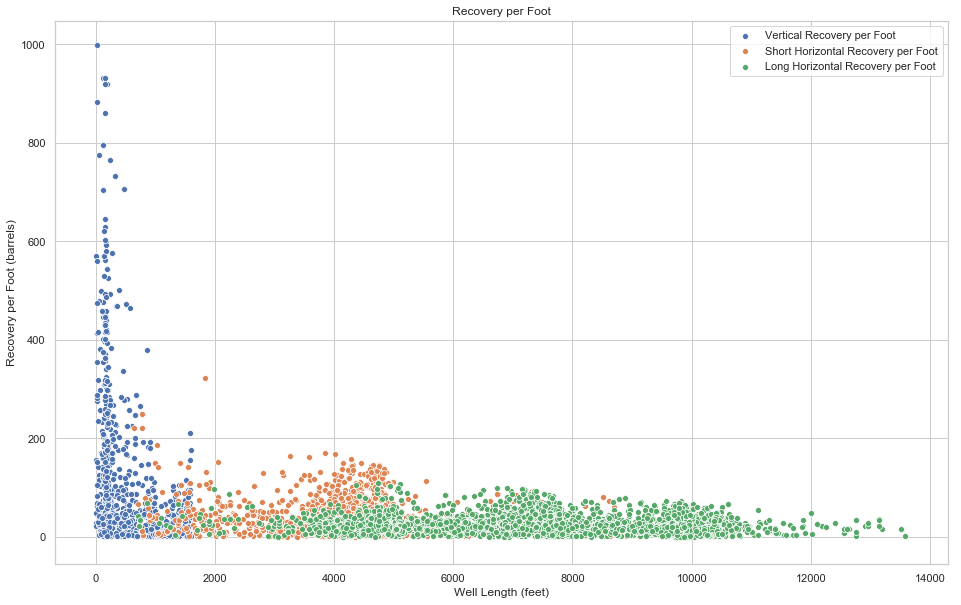

In [59]:
plt.figure(figsize=(16, 10))

sns.scatterplot(x='gross_perfs', y="recovery_per_foot", data=verticals)
sns.scatterplot(x='gross_perfs', y="recovery_per_foot", data=short_horizontals)
sns.scatterplot(x='gross_perfs', y="recovery_per_foot", data=long_horizontals)

plt.title('Recovery per Foot')
plt.xlabel('Well Length (feet)')
plt.ylabel('Recovery per Foot (barrels)')

plt.legend(['Vertical Recovery per Foot', 'Short Horizontal Recovery per Foot', 'Long Horizontal Recovery per Foot'], loc='upper right')

In [40]:
ordered_df = df.sort_values(['lateral_class']).reset_index(drop=True)

Text(0.5, 1.0, 'Recovery by Grouped Lateral Length')

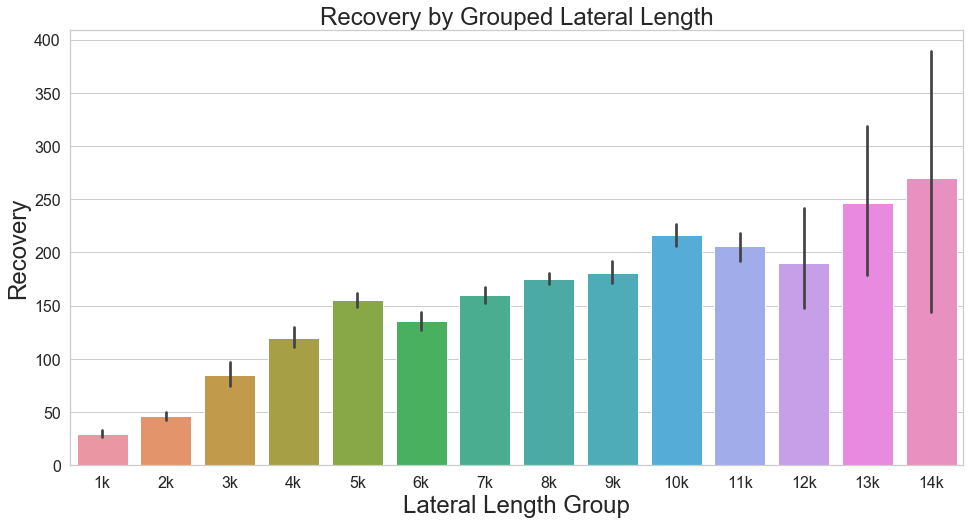

In [41]:
sns.set(style='whitegrid')
plt.figure(figsize=(16,8))
ax = sns.barplot(x='lateral_class', y='recovery', data=ordered_df)
ax.set(xticklabels=['1k', '2k', '3k', '4k', '5k', '6k', '7k', '8k', '9k', '10k', '11k', '12k', '13k', '14k'])
plt.xlabel('Lateral Length Group', fontsize=24)
plt.ylabel('Recovery', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Recovery by Grouped Lateral Length', fontsize=24)

Text(0.5, 1.0, 'Recovery by Grouped Lateral Length of Horizontal Wells')

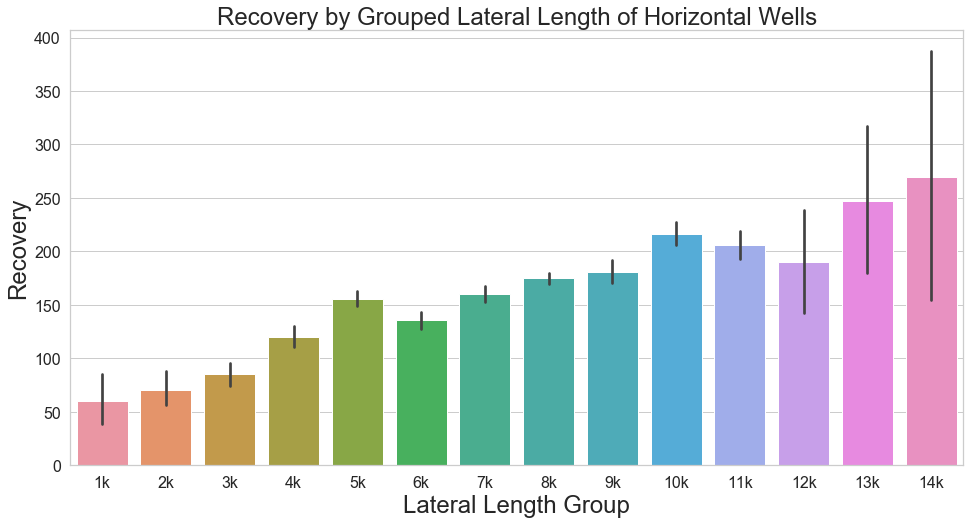

In [45]:
sns.set(style='whitegrid')
plt.figure(figsize=(16,8))
ax = sns.barplot(x='lateral_class', y='recovery', data=ordered_df[ordered_df.direction=='Horizontal'])
ax.set(xticklabels=['1k', '2k', '3k', '4k', '5k', '6k', '7k', '8k', '9k', '10k', '11k', '12k', '13k', '14k'])
plt.xlabel('Lateral Length Group', fontsize=24)
plt.ylabel('Recovery', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Recovery by Grouped Lateral Length of Horizontal Wells', fontsize=24)

Text(0.5, 1.0, 'Recovery Per Foot by Grouped Lateral Length')

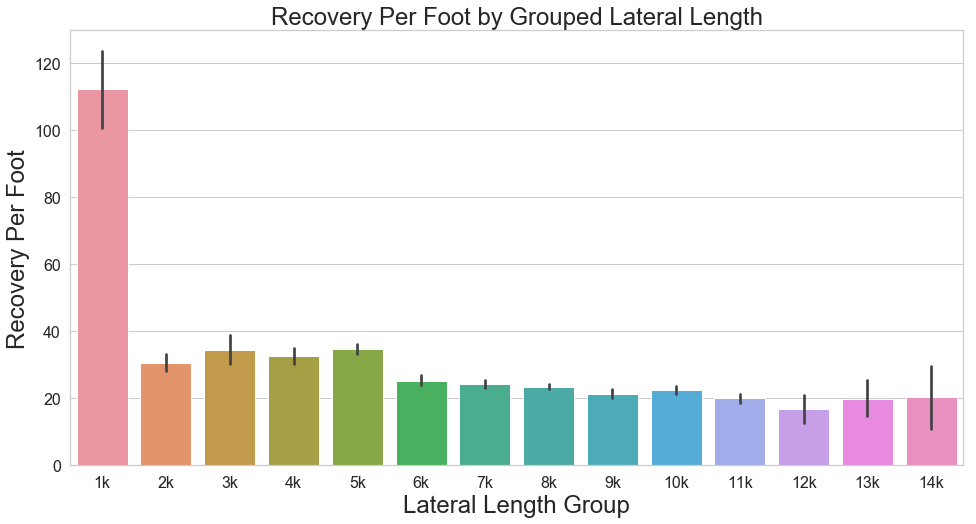

In [43]:
sns.set(style='whitegrid')
plt.figure(figsize=(16,8))
ax = sns.barplot(x='lateral_class', y='recovery_per_foot', data=ordered_df)
ax.set(xticklabels=['1k', '2k', '3k', '4k', '5k', '6k', '7k', '8k', '9k', '10k', '11k', '12k', '13k', '14k'])
plt.xlabel('Lateral Length Group', fontsize=24)
plt.ylabel('Recovery Per Foot', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Recovery Per Foot by Grouped Lateral Length', fontsize=24)

Text(0.5, 1.0, 'Recovery Per Foot by Grouped Lateral Length of Horizontal Wells')

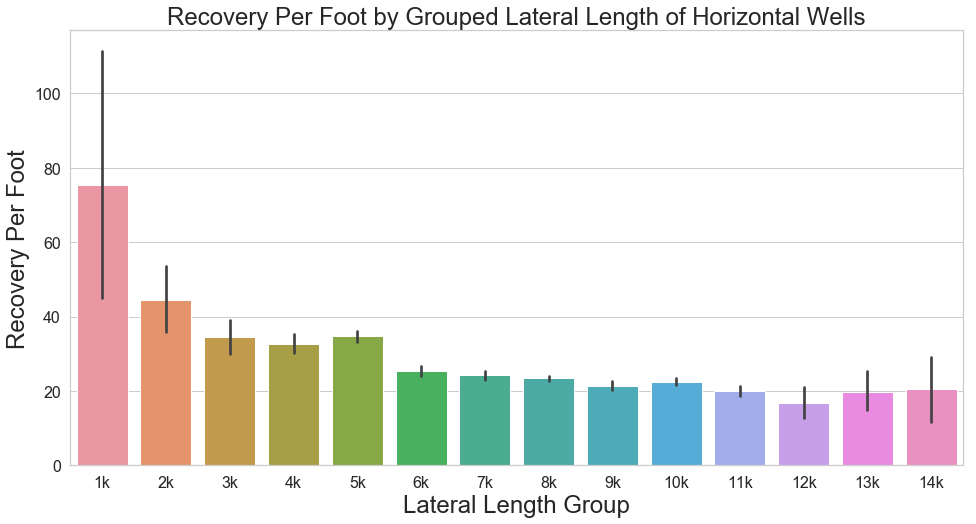

In [44]:
sns.set(style='whitegrid')
plt.figure(figsize=(16,8))
ax = sns.barplot(x='lateral_class', y='recovery_per_foot', data=ordered_df[ordered_df.direction=='Horizontal'])
ax.set(xticklabels=['1k', '2k', '3k', '4k', '5k', '6k', '7k', '8k', '9k', '10k', '11k', '12k', '13k', '14k'])
plt.xlabel('Lateral Length Group', fontsize=24)
plt.ylabel('Recovery Per Foot', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Recovery Per Foot by Grouped Lateral Length of Horizontal Wells', fontsize=24)

## Visualize recovery and recovery per foot vs the lateral class for each of the two horizontal clusters

In [46]:
short_horizontal_df = df[df.cluster_id==0]
ordered_df_short_horizontal = short_horizontal_df.sort_values(['lateral_class']).reset_index(drop=True)

Text(0.5, 1.0, 'Recovery by Grouped Lateral Length for Shorter Horizontals')

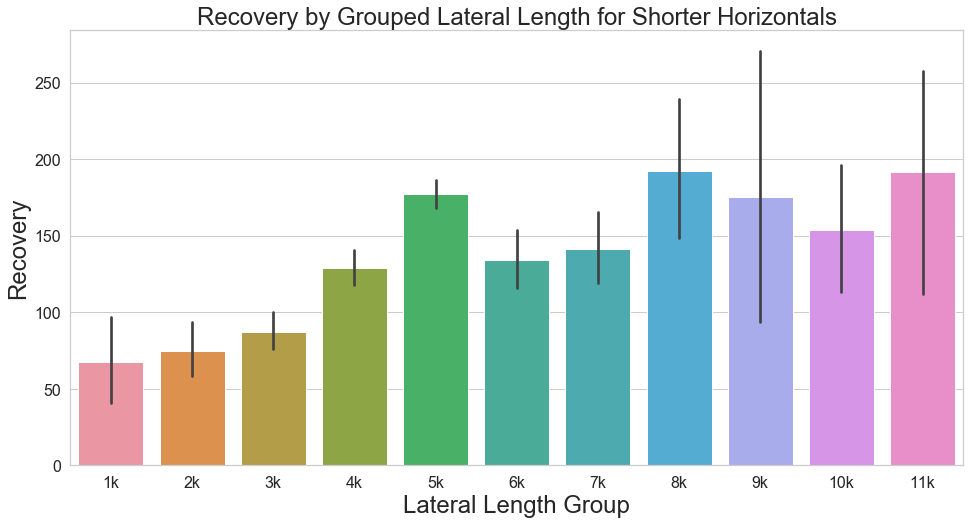

In [47]:
sns.set(style='whitegrid')
plt.figure(figsize=(16,8))
ax = sns.barplot(x='lateral_class', y='recovery', data=ordered_df_short_horizontal)
ax.set(xticklabels=['1k', '2k', '3k', '4k', '5k', '6k', '7k', '8k', '9k', '10k', '11k', '12k', '13k', '14k'])
plt.xlabel('Lateral Length Group', fontsize=24)
plt.ylabel('Recovery', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Recovery by Grouped Lateral Length for Shorter Horizontals', fontsize=24)

Text(0.5, 1.0, 'Recovery Per Foot by Grouped Lateral Length for Shorter Horizontals')

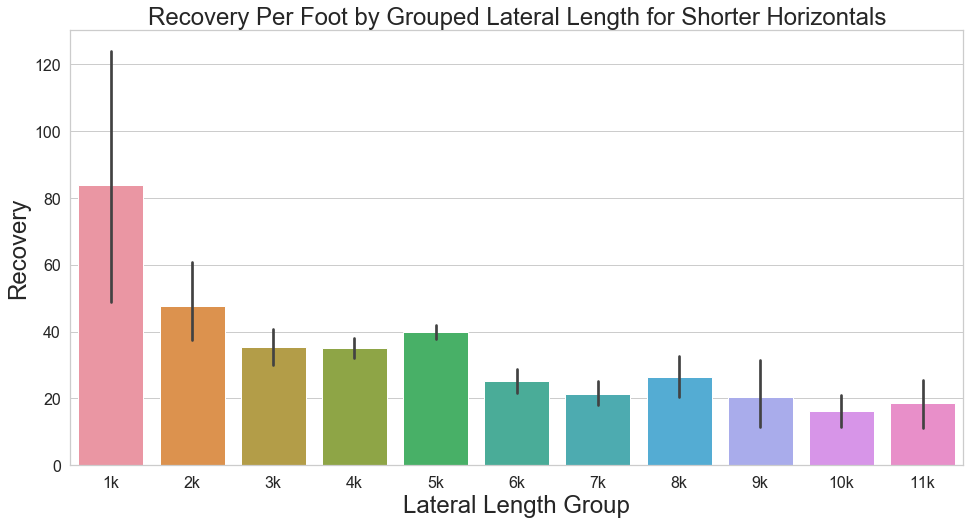

In [48]:
sns.set(style='whitegrid')
plt.figure(figsize=(16,8))
ax = sns.barplot(x='lateral_class', y='recovery_per_foot', data=ordered_df_short_horizontal)
ax.set(xticklabels=['1k', '2k', '3k', '4k', '5k', '6k', '7k', '8k', '9k', '10k', '11k', '12k', '13k', '14k'])
plt.xlabel('Lateral Length Group', fontsize=24)
plt.ylabel('Recovery', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Recovery Per Foot by Grouped Lateral Length for Shorter Horizontals', fontsize=24)

In [51]:
long_horizontal_df = df[df.cluster_id==2]
ordered_df_long_horizontal = long_horizontal_df.sort_values(['lateral_class']).reset_index(drop=True)

Text(0.5, 1.0, 'Recovery by Grouped Lateral Length for Longer Horizontals')

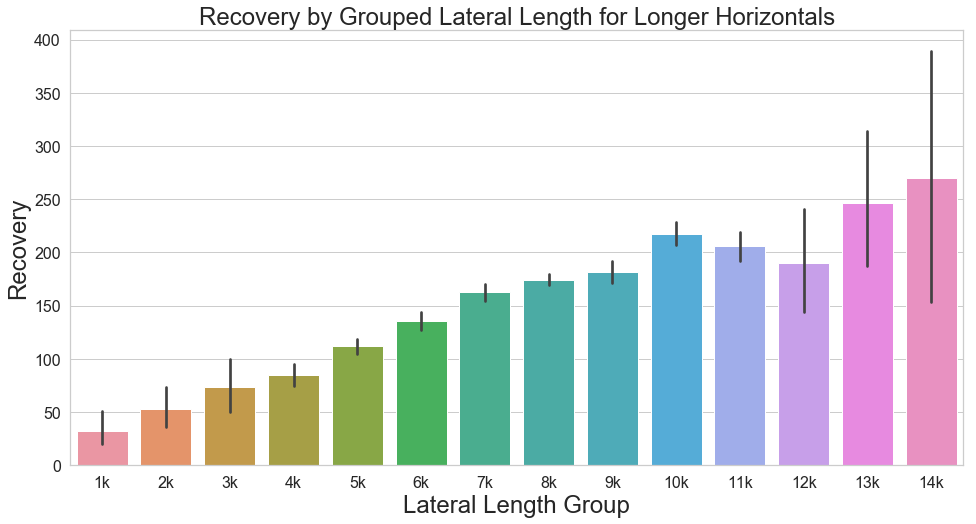

In [52]:
sns.set(style='whitegrid')
plt.figure(figsize=(16,8))
ax = sns.barplot(x='lateral_class', y='recovery', data=ordered_df_long_horizontal)
ax.set(xticklabels=['1k', '2k', '3k', '4k', '5k', '6k', '7k', '8k', '9k', '10k', '11k', '12k', '13k', '14k'])
plt.xlabel('Lateral Length Group', fontsize=24)
plt.ylabel('Recovery', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Recovery by Grouped Lateral Length for Longer Horizontals', fontsize=24)

Text(0.5, 1.0, 'Recovery Per Foot by Grouped Lateral Length for Longer Horizontals')

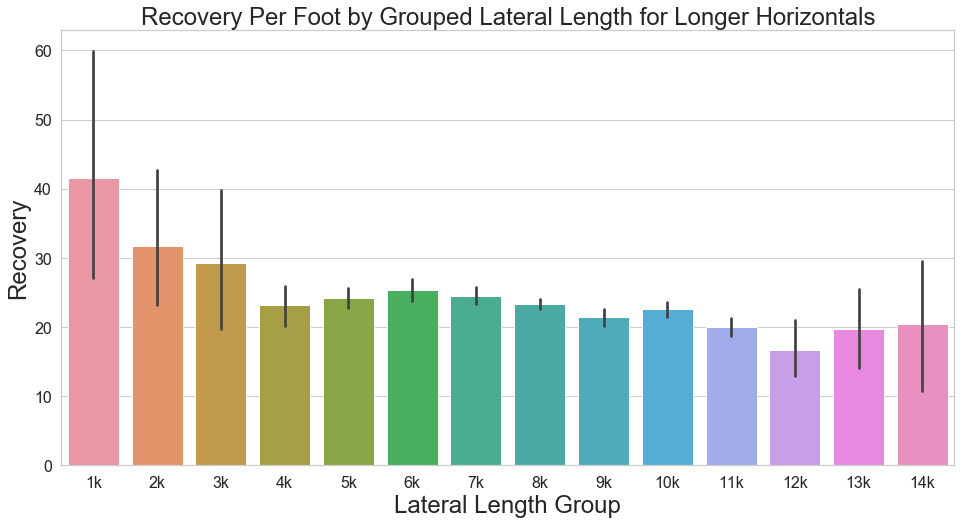

In [53]:
sns.set(style='whitegrid')
plt.figure(figsize=(16,8))
ax = sns.barplot(x='lateral_class', y='recovery_per_foot', data=ordered_df_long_horizontal)
ax.set(xticklabels=['1k', '2k', '3k', '4k', '5k', '6k', '7k', '8k', '9k', '10k', '11k', '12k', '13k', '14k'])
plt.xlabel('Lateral Length Group', fontsize=24)
plt.ylabel('Recovery', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Recovery Per Foot by Grouped Lateral Length for Longer Horizontals', fontsize=24)

# Improve Results

## Algorithm Tuning

## Ensemble Methods

### Bagging

### Boosting

### Blending

## Extreme Feature Engineering